In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import tensorflow as tf
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


# Modeling Chilled Water Energy

In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
flowdata = dp.readfile('../data/processed/flow.pkl')

# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
# ahu = ahu.drop(columns=['hwe', 'cwe'])

In [5]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, flow])

# rearranging columns
#df = df[['oat', 'orh', 'sat', 'Ghi', 'flow', 'totale']]

In [6]:
df.head()

,oat,orh,sat,hwe,cwe,totale,Ghi,flow
2018-07-12 13:55:00,89.554909,76.0,75.443275,0.0,35.590466,35.590466,872.0,43.108143
2018-07-12 14:00:00,89.863190,76.0,75.443275,0.0,33.027813,33.027813,866.0,45.760704
2018-07-12 14:05:00,89.863190,76.0,75.443275,0.0,31.769627,31.769627,859.0,45.840881
2018-07-12 14:10:00,90.484146,69.0,75.443275,0.0,34.195641,34.195641,848.0,43.372566
2018-07-12 14:15:00,90.826981,69.0,75.443275,0.0,31.082222,31.082222,836.0,38.218956


In [7]:
# smooth the hwe and cwe
df_smoothed = dp.dfsmoothing(
    df,
    column_names=list(df.columns),
    Wn=0.08  # 0.15
)

Finished 'dataframeplot' in 0.1011 secs


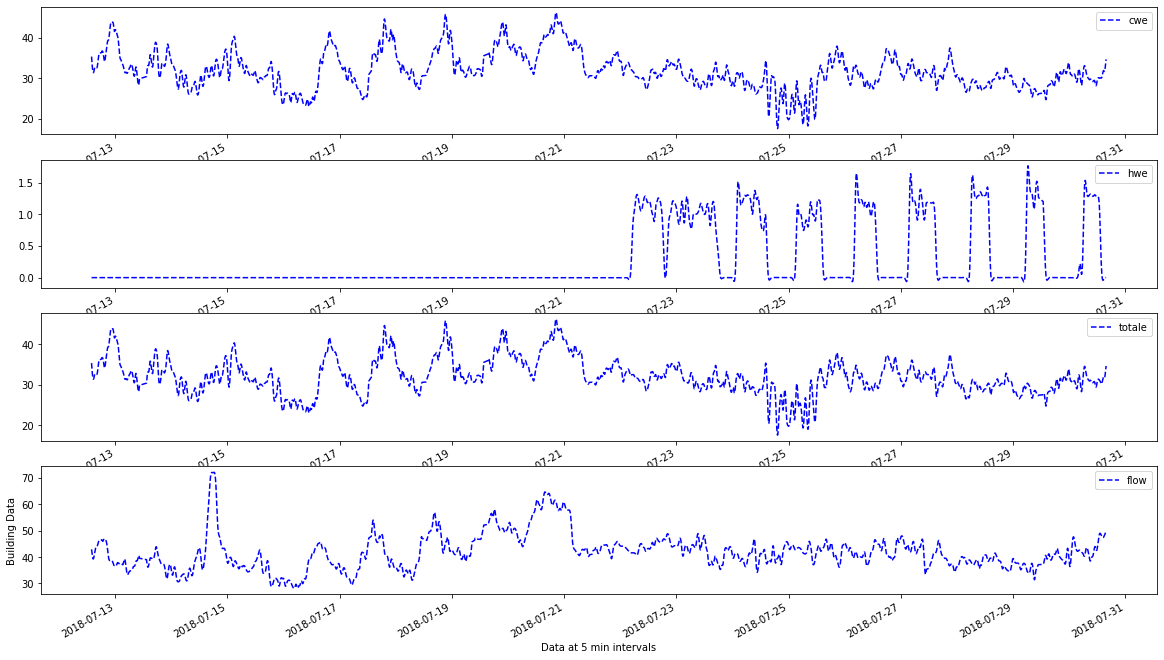

In [8]:
dp.dataframeplot(df=df_smoothed.loc[df_smoothed.index[0:5000],['cwe','hwe','totale','flow']],
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

In [9]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df_smoothed, subsequence=True, period=1, days=7, hours=0)

In [10]:
len(dflist)

10

In [11]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'Ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [12]:
weeklist[0].keys()
for key,value in weeklist[0].items():
    print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)


In [13]:
path = '../results/lstm/'
!rm -rf ../results/lstm

In [14]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [15]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [16]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4, #4
    'lstm_no_layers': 1, #1
    'dense_hidden_units':1, #1
    'dense_no_layers': 8 #8
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        model = mp.lstm_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        # modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=600, initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno+1)

  0%|          | 0/10 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1511 samples, validate on 504 samples



Epoch 1/600
 - 1s - loss: 0.2297 - val_loss: 0.1354
Epoch 2/600
 - 0s - loss: 0.0955 - val_loss: 0.0559
Epoch 3/600
 - 0s - loss: 0.0529 - val_loss: 0.0417
Epoch 4/600
 - 0s - loss: 0.0462 - val_loss: 0.0410
Epoch 5/600
 - 0s - loss: 0.0450 - val_loss: 0.0410
Epoch 6/600
 - 0s - loss: 0.0444 - val_loss: 0.0409
Epoch 7/600
 - 0s - loss: 0.0437 - val_loss: 0.0407
Epoch 8/600
 - 0s - loss: 0.0430 - val_loss: 0.0405
Epoch 9/600
 - 0s - loss: 0.0423 - val_loss: 0.0403
Epoch 10/600
 - 0s - loss: 0.0417 - val_loss: 0.0401
Epoch 11/600
 - 0s - loss: 0.0411 - val_loss: 0.0398
Epoch 12/600
 - 0s - loss: 0.0406 - val_loss: 0.0394
Epoch 13/600
 - 0s - loss: 0.0400 - val_loss: 0.0391
Epoch 14/600
 - 0s - loss: 0.0395 - val_loss: 0.0387
Epoch 15/600
 - 0s - loss: 0.0390 - val_loss: 0.0383
Epoch 16/600
 - 0s - loss: 0.0385 - val_loss: 0.0379
Epoch 17/600
 

 10%|█         | 1/10 [00:42<06:20, 42.32s/it]

Train on 1511 samples, validate on 504 samples
Epoch 73/600
 - 1s - loss: 0.3879 - val_loss: 0.0316
Epoch 74/600
 - 0s - loss: 0.2955 - val_loss: 0.0173
Epoch 75/600
 - 0s - loss: 0.1953 - val_loss: 0.0297
Epoch 76/600
 - 0s - loss: 0.0966 - val_loss: 0.1126
Epoch 77/600
 - 0s - loss: 0.0439 - val_loss: 0.1227
Epoch 78/600
 - 0s - loss: 0.0406 - val_loss: 0.1316
Epoch 79/600
 - 0s - loss: 0.0381 - val_loss: 0.1397
Epoch 80/600
 - 0s - loss: 0.0361 - val_loss: 0.1471
Epoch 81/600
 - 0s - loss: 0.0344 - val_loss: 0.1478
Epoch 82/600
 - 0s - loss: 0.0343 - val_loss: 0.1485


 20%|██        | 2/10 [00:55<04:27, 33.50s/it]

Train on 1511 samples, validate on 504 samples
Epoch 83/600
 - 1s - loss: 0.2321 - val_loss: 0.1080
Epoch 84/600
 - 0s - loss: 0.1582 - val_loss: 0.0521
Epoch 85/600
 - 0s - loss: 0.0983 - val_loss: 0.0271
Epoch 86/600
 - 0s - loss: 0.0714 - val_loss: 0.0255
Epoch 87/600
 - 0s - loss: 0.0640 - val_loss: 0.0255
Epoch 88/600
 - 0s - loss: 0.0619 - val_loss: 0.0251
Epoch 89/600
 - 0s - loss: 0.0607 - val_loss: 0.0246
Epoch 90/600
 - 0s - loss: 0.0595 - val_loss: 0.0239
Epoch 91/600
 - 0s - loss: 0.0582 - val_loss: 0.0232
Epoch 92/600
 - 0s - loss: 0.0569 - val_loss: 0.0225
Epoch 93/600
 - 0s - loss: 0.0555 - val_loss: 0.0218
Epoch 94/600
 - 0s - loss: 0.0539 - val_loss: 0.0211
Epoch 95/600
 - 0s - loss: 0.0521 - val_loss: 0.0204
Epoch 96/600
 - 0s - loss: 0.0502 - val_loss: 0.0197
Epoch 97/600
 - 0s - loss: 0.0480 - val_loss: 0.0190
Epoch 98/600
 - 0s - loss: 0.0455 - val_loss: 0.0184
Epoch 99/600
 - 0s - loss: 0.0427 - val_loss: 0.0178
Epoch 100/600
 - 0s - loss: 0.0396 - val_loss: 0.017

 30%|███       | 3/10 [01:36<04:11, 35.93s/it]

Train on 1511 samples, validate on 504 samples
Epoch 154/600
 - 1s - loss: 0.4645 - val_loss: 0.3546
Epoch 155/600
 - 0s - loss: 0.3101 - val_loss: 0.2313
Epoch 156/600
 - 0s - loss: 0.1816 - val_loss: 0.1074
Epoch 157/600
 - 0s - loss: 0.0963 - val_loss: 0.0619
Epoch 158/600
 - 0s - loss: 0.0754 - val_loss: 0.0569
Epoch 159/600
 - 0s - loss: 0.0683 - val_loss: 0.0554
Epoch 160/600
 - 0s - loss: 0.0640 - val_loss: 0.0546
Epoch 161/600
 - 0s - loss: 0.0611 - val_loss: 0.0541
Epoch 162/600
 - 0s - loss: 0.0592 - val_loss: 0.0537
Epoch 163/600
 - 0s - loss: 0.0579 - val_loss: 0.0534
Epoch 164/600
 - 0s - loss: 0.0569 - val_loss: 0.0531
Epoch 165/600
 - 0s - loss: 0.0561 - val_loss: 0.0528
Epoch 166/600
 - 0s - loss: 0.0555 - val_loss: 0.0525
Epoch 167/600
 - 0s - loss: 0.0549 - val_loss: 0.0522
Epoch 168/600
 - 0s - loss: 0.0544 - val_loss: 0.0520
Epoch 169/600
 - 0s - loss: 0.0539 - val_loss: 0.0517
Epoch 170/600
 - 0s - loss: 0.0534 - val_loss: 0.0515
Epoch 171/600
 - 0s - loss: 0.0529 

 40%|████      | 4/10 [02:11<03:32, 35.47s/it]

Train on 1511 samples, validate on 504 samples
Epoch 209/600
 - 1s - loss: 0.0437 - val_loss: 0.0835
Epoch 210/600
 - 0s - loss: 0.0313 - val_loss: 0.0829
Epoch 211/600
 - 0s - loss: 0.0297 - val_loss: 0.0803
Epoch 212/600
 - 0s - loss: 0.0288 - val_loss: 0.0778
Epoch 213/600
 - 0s - loss: 0.0281 - val_loss: 0.0756
Epoch 214/600
 - 0s - loss: 0.0276 - val_loss: 0.0738
Epoch 215/600
 - 0s - loss: 0.0272 - val_loss: 0.0724
Epoch 216/600
 - 0s - loss: 0.0269 - val_loss: 0.0711
Epoch 217/600
 - 0s - loss: 0.0266 - val_loss: 0.0700
Epoch 218/600
 - 0s - loss: 0.0263 - val_loss: 0.0690
Epoch 219/600
 - 0s - loss: 0.0260 - val_loss: 0.0680
Epoch 220/600
 - 0s - loss: 0.0258 - val_loss: 0.0671
Epoch 221/600
 - 0s - loss: 0.0255 - val_loss: 0.0661
Epoch 222/600
 - 0s - loss: 0.0252 - val_loss: 0.0652
Epoch 223/600
 - 0s - loss: 0.0249 - val_loss: 0.0642
Epoch 224/600
 - 0s - loss: 0.0246 - val_loss: 0.0632
Epoch 225/600
 - 0s - loss: 0.0243 - val_loss: 0.0619
Epoch 226/600
 - 0s - loss: 0.0240 

 50%|█████     | 5/10 [02:48<02:59, 35.95s/it]

Train on 1511 samples, validate on 504 samples
Epoch 270/600
 - 1s - loss: 0.1651 - val_loss: 0.0277
Epoch 271/600
 - 0s - loss: 0.0523 - val_loss: 0.0401
Epoch 272/600
 - 0s - loss: 0.0401 - val_loss: 0.0406
Epoch 273/600
 - 0s - loss: 0.0356 - val_loss: 0.0412
Epoch 274/600
 - 0s - loss: 0.0354 - val_loss: 0.0417
Epoch 275/600
 - 0s - loss: 0.0352 - val_loss: 0.0421
Epoch 276/600
 - 0s - loss: 0.0350 - val_loss: 0.0424
Epoch 277/600
 - 0s - loss: 0.0346 - val_loss: 0.0424
Epoch 278/600
 - 0s - loss: 0.0346 - val_loss: 0.0425


 60%|██████    | 6/10 [03:01<01:56, 29.22s/it]

Train on 1511 samples, validate on 504 samples
Epoch 279/600
 - 1s - loss: 0.0873 - val_loss: 0.0959
Epoch 280/600
 - 0s - loss: 0.0651 - val_loss: 0.0742
Epoch 281/600
 - 0s - loss: 0.0554 - val_loss: 0.0647
Epoch 282/600
 - 0s - loss: 0.0515 - val_loss: 0.0581
Epoch 283/600
 - 0s - loss: 0.0488 - val_loss: 0.0535
Epoch 284/600
 - 0s - loss: 0.0469 - val_loss: 0.0503
Epoch 285/600
 - 0s - loss: 0.0454 - val_loss: 0.0479
Epoch 286/600
 - 0s - loss: 0.0440 - val_loss: 0.0459
Epoch 287/600
 - 0s - loss: 0.0427 - val_loss: 0.0441
Epoch 288/600
 - 0s - loss: 0.0414 - val_loss: 0.0422
Epoch 289/600
 - 0s - loss: 0.0401 - val_loss: 0.0401
Epoch 290/600
 - 0s - loss: 0.0386 - val_loss: 0.0377
Epoch 291/600
 - 0s - loss: 0.0370 - val_loss: 0.0351
Epoch 292/600
 - 0s - loss: 0.0352 - val_loss: 0.0328
Epoch 293/600
 - 0s - loss: 0.0336 - val_loss: 0.0309
Epoch 294/600
 - 0s - loss: 0.0322 - val_loss: 0.0292
Epoch 295/600
 - 0s - loss: 0.0307 - val_loss: 0.0276
Epoch 296/600
 - 0s - loss: 0.0294 

 70%|███████   | 7/10 [03:26<01:23, 27.93s/it]

Train on 1511 samples, validate on 504 samples
Epoch 314/600
 - 1s - loss: 0.1374 - val_loss: 0.0415
Epoch 315/600
 - 0s - loss: 0.0604 - val_loss: 0.0217
Epoch 316/600
 - 0s - loss: 0.0310 - val_loss: 0.0267
Epoch 317/600
 - 0s - loss: 0.0258 - val_loss: 0.0243
Epoch 318/600
 - 0s - loss: 0.0240 - val_loss: 0.0243
Epoch 319/600
 - 0s - loss: 0.0238 - val_loss: 0.0244
Epoch 320/600
 - 0s - loss: 0.0236 - val_loss: 0.0245
Epoch 321/600
 - 0s - loss: 0.0234 - val_loss: 0.0245
Epoch 322/600
 - 0s - loss: 0.0232 - val_loss: 0.0246
Epoch 323/600
 - 0s - loss: 0.0232 - val_loss: 0.0246


 80%|████████  | 8/10 [03:40<00:47, 23.55s/it]

Train on 1511 samples, validate on 504 samples
Epoch 324/600
 - 1s - loss: 0.1467 - val_loss: 0.0187
Epoch 325/600
 - 0s - loss: 0.0248 - val_loss: 0.0125
Epoch 326/600
 - 0s - loss: 0.0192 - val_loss: 0.0097
Epoch 327/600
 - 0s - loss: 0.0181 - val_loss: 0.0082
Epoch 328/600
 - 0s - loss: 0.0174 - val_loss: 0.0074
Epoch 329/600
 - 0s - loss: 0.0170 - val_loss: 0.0069
Epoch 330/600
 - 0s - loss: 0.0168 - val_loss: 0.0066
Epoch 331/600
 - 0s - loss: 0.0167 - val_loss: 0.0065
Epoch 332/600
 - 0s - loss: 0.0166 - val_loss: 0.0064
Epoch 333/600
 - 0s - loss: 0.0165 - val_loss: 0.0064
Epoch 334/600
 - 0s - loss: 0.0164 - val_loss: 0.0063
Epoch 335/600
 - 0s - loss: 0.0163 - val_loss: 0.0063
Epoch 336/600
 - 0s - loss: 0.0166 - val_loss: 0.0050
Epoch 337/600
 - 0s - loss: 0.0132 - val_loss: 0.0055
Epoch 338/600
 - 0s - loss: 0.0120 - val_loss: 0.0060
Epoch 339/600
 - 0s - loss: 0.0116 - val_loss: 0.0064
Epoch 340/600
 - 0s - loss: 0.0111 - val_loss: 0.0064
Epoch 341/600
 - 0s - loss: 0.0111 

 90%|█████████ | 9/10 [03:58<00:22, 22.10s/it]

Train on 1511 samples, validate on 504 samples
Epoch 345/600
 - 1s - loss: 0.1836 - val_loss: 0.0548
Epoch 346/600
 - 0s - loss: 0.0870 - val_loss: 0.0299
Epoch 347/600
 - 0s - loss: 0.0750 - val_loss: 0.0262
Epoch 348/600
 - 0s - loss: 0.0711 - val_loss: 0.0227
Epoch 349/600
 - 0s - loss: 0.0681 - val_loss: 0.0209
Epoch 350/600
 - 0s - loss: 0.0661 - val_loss: 0.0198
Epoch 351/600
 - 0s - loss: 0.0644 - val_loss: 0.0188
Epoch 352/600
 - 0s - loss: 0.0624 - val_loss: 0.0179
Epoch 353/600
 - 0s - loss: 0.0602 - val_loss: 0.0168
Epoch 354/600
 - 0s - loss: 0.0576 - val_loss: 0.0157
Epoch 355/600
 - 0s - loss: 0.0545 - val_loss: 0.0145
Epoch 356/600
 - 0s - loss: 0.0510 - val_loss: 0.0131
Epoch 357/600
 - 0s - loss: 0.0469 - val_loss: 0.0117
Epoch 358/600
 - 0s - loss: 0.0423 - val_loss: 0.0102
Epoch 359/600
 - 0s - loss: 0.0377 - val_loss: 0.0089
Epoch 360/600
 - 0s - loss: 0.0338 - val_loss: 0.0082
Epoch 361/600
 - 0s - loss: 0.0310 - val_loss: 0.0080
Epoch 362/600
 - 0s - loss: 0.0293 

100%|██████████| 10/10 [04:19<00:00, 25.93s/it]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/lstm/5min Results_File.txt


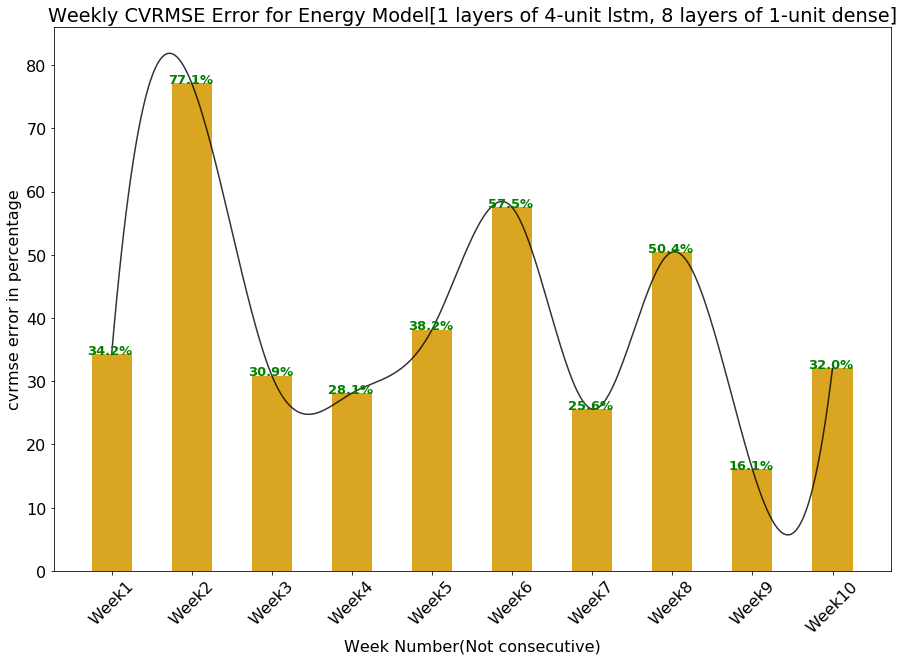

In [17]:
# Open a file
fo = open(path+"5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = path,
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly CVRMSE Error for Energy Model[{} layers of {}-unit lstm, {} layers of {}-unit dense]'.format(config['lstm_no_layers'],config['lstm_hidden_units'], config['dense_no_layers'],config['dense_hidden_units']),
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)

# Modeling Hot Water Energy

In [3]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothed_buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [4]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.085561,73.399236,84.996351,12.247199,0.061145,523.448686,72.438053,0.004498,6.769096,107.185437,98.426348
2018-11-16 10:10:00,31.084241,73.174948,85.162961,12.049303,1.239401,530.628172,72.436722,0.004635,7.174604,108.380930,97.960950
2018-11-16 10:15:00,31.082809,72.953222,85.338500,11.855933,2.364778,537.912446,72.435385,0.004748,7.570829,109.490329,97.490620
2018-11-16 10:20:00,31.081329,72.737975,85.531478,11.673648,3.409979,545.266988,72.434065,0.004843,7.942075,110.468679,97.028119
2018-11-16 10:25:00,31.079893,72.531779,85.748990,11.508193,4.338237,552.652147,72.432798,0.004924,8.275292,111.291654,96.587022


In [5]:
df.tail()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2020-02-12 06:30:00,59.062424,73.257595,58.469692,-0.340155,2.867506,-0.000006,72.647619,0.000745,21.591509,117.618939,108.524975
2020-02-12 06:40:00,60.396597,73.057491,58.371276,-0.321477,2.205102,-0.000008,72.647619,0.000752,23.946071,118.739598,109.623482
2020-02-12 06:50:00,61.679009,72.877133,58.280555,-0.292277,1.521950,-0.000009,72.647619,0.000758,26.056081,119.688174,110.793781
2020-02-12 06:55:00,62.892696,72.716843,58.198122,-0.257719,0.838166,-0.000009,72.647619,0.000765,27.914109,120.468804,111.982709
2020-02-12 07:00:00,64.022514,72.575756,58.124085,-0.221789,0.181070,-0.000009,72.647619,0.000771,29.531381,121.112145,113.159061


In [6]:
df.shape[0]/2016

51.910714285714285

In [7]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df[['oat', 'orh', 'sat', 'ghi', 'hw_sf', 'hwe', 'hw_st','hw_rt']],
                      subsequence=True,
                      period=1,
                      days=21,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 1


In [8]:
# Creating a list of 7 day dataframes for training; here the weeks are continuous
dflist = dp.df2dflist(dflist[0][['oat', 'orh', 'sat', 'ghi', 'hw_sf', 'hwe', 'hw_st','hw_rt']],
                      subsequence=True,
                      period=1,
                      days=7,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 3


In [9]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:  # [:40]:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [10]:
weeklist[0].keys()
for key,value in weeklist[0].items():
    print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 6)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 6)
name: y_test, value: (504, 1, 1)


### Run from here to rerun training with same data

In [11]:
path = '../results/lstm_hwe_2/'
!rm -rf ../results/lstm_hwe_2

In [12]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [13]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [14]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 8,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 2,
    'train_epochs':2000
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        model = mp.lstm_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=config['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno+1)

  0%|          | 0/3 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1511 samples, validate on 504 samples



Epoch 1/2000
 - 1s - loss: 0.1672 - val_loss: 0.0915
Epoch 2/2000
 - 0s - loss: 0.0514 - val_loss: 0.0343
Epoch 3/2000
 - 0s - loss: 0.0649 - val_loss: 0.0357
Epoch 4/2000
 - 0s - loss: 0.0574 - val_loss: 0.0335
Epoch 5/2000
 - 0s - loss: 0.0564 - val_loss: 0.0324
Epoch 6/2000
 - 0s - loss: 0.0558 - val_loss: 0.0311
Epoch 7/2000
 - 0s - loss: 0.0550 - val_loss: 0.0298
Epoch 8/2000
 - 0s - loss: 0.0546 - val_loss: 0.0286
Epoch 9/2000
 - 0s - loss: 0.0540 - val_loss: 0.0277
Epoch 10/2000
 - 0s - loss: 0.0536 - val_loss: 0.0270
Epoch 11/2000
 - 0s - loss: 0.0530 - val_loss: 0.0262
Epoch 12/2000
 - 0s - loss: 0.0525 - val_loss: 0.0256
Epoch 13/2000
 - 0s - loss: 0.0521 - val_loss: 0.0249
Epoch 14/2000
 - 0s - loss: 0.0516 - val_loss: 0.0243
Epoch 15/2000
 - 0s - loss: 0.0512 - val_loss: 0.0238
Epoch 16/2000
 - 0s - loss: 0.0506 - val_loss: 0.023

 33%|███▎      | 1/3 [00:37<01:15, 37.89s/it]

Train on 1511 samples, validate on 504 samples
Epoch 46/2000
 - 0s - loss: 0.0774 - val_loss: 0.1397
Epoch 47/2000
 - 0s - loss: 0.0770 - val_loss: 0.1391
Epoch 48/2000
 - 0s - loss: 0.0766 - val_loss: 0.1384
Epoch 49/2000
 - 0s - loss: 0.0762 - val_loss: 0.1378
Epoch 50/2000
 - 0s - loss: 0.0758 - val_loss: 0.1373
Epoch 51/2000
 - 0s - loss: 0.0754 - val_loss: 0.1367
Epoch 52/2000
 - 0s - loss: 0.0751 - val_loss: 0.1361
Epoch 53/2000
 - 0s - loss: 0.0748 - val_loss: 0.1356
Epoch 54/2000
 - 0s - loss: 0.0744 - val_loss: 0.1351
Epoch 55/2000
 - 0s - loss: 0.0741 - val_loss: 0.1345
Epoch 56/2000
 - 0s - loss: 0.0738 - val_loss: 0.1340
Epoch 57/2000
 - 0s - loss: 0.0735 - val_loss: 0.1335
Epoch 58/2000
 - 0s - loss: 0.0731 - val_loss: 0.1330
Epoch 59/2000
 - 0s - loss: 0.0728 - val_loss: 0.1325
Epoch 60/2000
 - 0s - loss: 0.0725 - val_loss: 0.1320
Epoch 61/2000
 - 0s - loss: 0.0722 - val_loss: 0.1315
Epoch 62/2000
 - 0s - loss: 0.0720 - val_loss: 0.1311
Epoch 63/2000
 - 0s - loss: 0.0717 

 - 0s - loss: 0.0464 - val_loss: 0.0847
Epoch 196/2000
 - 0s - loss: 0.0462 - val_loss: 0.0844
Epoch 197/2000
 - 0s - loss: 0.0461 - val_loss: 0.0841
Epoch 198/2000
 - 0s - loss: 0.0460 - val_loss: 0.0839
Epoch 199/2000
 - 0s - loss: 0.0459 - val_loss: 0.0836
Epoch 200/2000
 - 0s - loss: 0.0457 - val_loss: 0.0833
Epoch 201/2000
 - 0s - loss: 0.0456 - val_loss: 0.0831
Epoch 202/2000
 - 0s - loss: 0.0455 - val_loss: 0.0828
Epoch 203/2000
 - 0s - loss: 0.0453 - val_loss: 0.0826
Epoch 204/2000
 - 0s - loss: 0.0452 - val_loss: 0.0823
Epoch 205/2000
 - 0s - loss: 0.0451 - val_loss: 0.0821
Epoch 206/2000
 - 0s - loss: 0.0450 - val_loss: 0.0818
Epoch 207/2000
 - 0s - loss: 0.0448 - val_loss: 0.0815
Epoch 208/2000
 - 0s - loss: 0.0447 - val_loss: 0.0813
Epoch 209/2000
 - 0s - loss: 0.0446 - val_loss: 0.0810
Epoch 210/2000
 - 0s - loss: 0.0445 - val_loss: 0.0808
Epoch 211/2000
 - 0s - loss: 0.0444 - val_loss: 0.0805
Epoch 212/2000
 - 0s - loss: 0.0442 - val_loss: 0.0803
Epoch 213/2000
 - 0s - lo

 - 0s - loss: 0.0334 - val_loss: 0.0550
Epoch 345/2000
 - 0s - loss: 0.0334 - val_loss: 0.0549
Epoch 346/2000
 - 0s - loss: 0.0333 - val_loss: 0.0548
Epoch 347/2000
 - 0s - loss: 0.0333 - val_loss: 0.0546
Epoch 348/2000
 - 0s - loss: 0.0332 - val_loss: 0.0545
Epoch 349/2000
 - 0s - loss: 0.0332 - val_loss: 0.0543
Epoch 350/2000
 - 0s - loss: 0.0331 - val_loss: 0.0542
Epoch 351/2000
 - 0s - loss: 0.0331 - val_loss: 0.0541
Epoch 352/2000
 - 0s - loss: 0.0330 - val_loss: 0.0539
Epoch 353/2000
 - 0s - loss: 0.0330 - val_loss: 0.0538
Epoch 354/2000
 - 0s - loss: 0.0329 - val_loss: 0.0537
Epoch 355/2000
 - 0s - loss: 0.0329 - val_loss: 0.0535
Epoch 356/2000
 - 0s - loss: 0.0328 - val_loss: 0.0534
Epoch 357/2000
 - 0s - loss: 0.0328 - val_loss: 0.0533
Epoch 358/2000
 - 0s - loss: 0.0327 - val_loss: 0.0531
Epoch 359/2000
 - 0s - loss: 0.0327 - val_loss: 0.0530
Epoch 360/2000
 - 0s - loss: 0.0327 - val_loss: 0.0529
Epoch 361/2000
 - 0s - loss: 0.0326 - val_loss: 0.0528
Epoch 362/2000
 - 0s - lo

 - 0s - loss: 0.0288 - val_loss: 0.0405
Epoch 494/2000
 - 0s - loss: 0.0288 - val_loss: 0.0404
Epoch 495/2000
 - 0s - loss: 0.0287 - val_loss: 0.0403
Epoch 496/2000
 - 0s - loss: 0.0287 - val_loss: 0.0403
Epoch 497/2000
 - 0s - loss: 0.0287 - val_loss: 0.0402
Epoch 498/2000
 - 0s - loss: 0.0287 - val_loss: 0.0402
Epoch 499/2000
 - 0s - loss: 0.0287 - val_loss: 0.0401
Epoch 500/2000
 - 0s - loss: 0.0287 - val_loss: 0.0400
Epoch 501/2000
 - 0s - loss: 0.0286 - val_loss: 0.0400
Epoch 502/2000
 - 0s - loss: 0.0286 - val_loss: 0.0399
Epoch 503/2000
 - 0s - loss: 0.0286 - val_loss: 0.0398
Epoch 504/2000
 - 0s - loss: 0.0286 - val_loss: 0.0398
Epoch 505/2000
 - 0s - loss: 0.0286 - val_loss: 0.0397
Epoch 506/2000
 - 0s - loss: 0.0286 - val_loss: 0.0397
Epoch 507/2000
 - 0s - loss: 0.0285 - val_loss: 0.0396
Epoch 508/2000
 - 0s - loss: 0.0285 - val_loss: 0.0395
Epoch 509/2000
 - 0s - loss: 0.0285 - val_loss: 0.0395
Epoch 510/2000
 - 0s - loss: 0.0285 - val_loss: 0.0394
Epoch 511/2000
 - 0s - lo

 67%|██████▋   | 2/3 [05:32<01:54, 114.97s/it]

Train on 1511 samples, validate on 504 samples
Epoch 569/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 570/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 571/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 572/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 573/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 574/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 575/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 576/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426
Epoch 577/2000
 - 0s - loss: 0.0453 - val_loss: 0.0426


100%|██████████| 3/3 [05:40<00:00, 113.56s/it]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/lstm_hwe_2/5min Results_File.txt


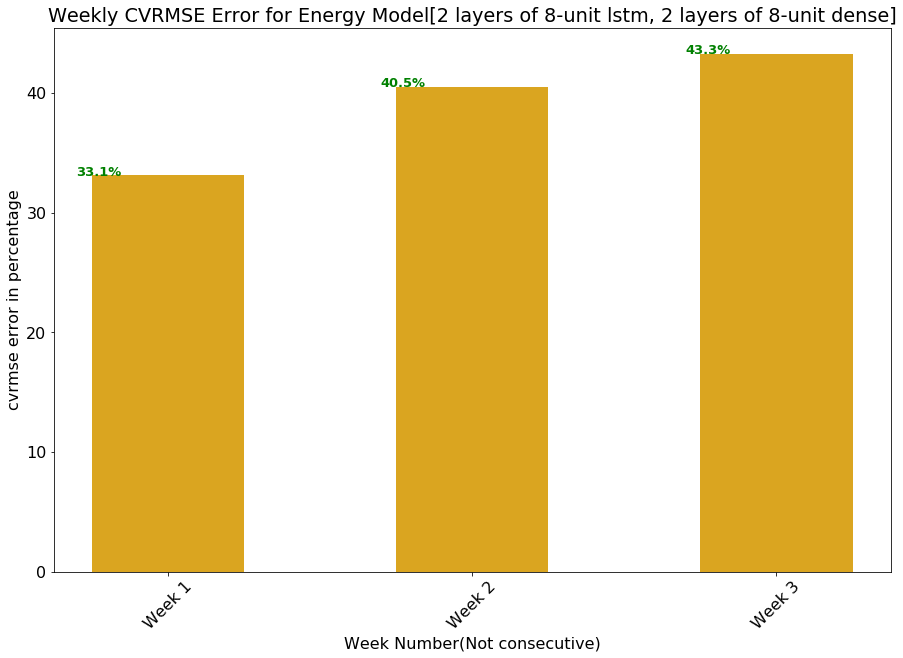

In [17]:
# Open a file
fo = open(path+"5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = path,
    smoothcurve = False,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly CVRMSE Error for Energy Model[{} layers of {}-unit lstm, {} layers of {}-unit dense]'.format(config['lstm_no_layers'],config['lstm_hidden_units'], config['dense_no_layers'],config['dense_hidden_units']),
    xticktype = 'Week '
)
pu.single_bar_plot(
    **plot_args
)